## Import Library

In [2]:
!pip install awswrangler -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 4.6.0 which is incompatible.
awscli 1.22.22 requires botocore==1.23.22, but you have botocore 1.29.138 which is incompatible.
awscli 1.22.22 requires s3transfer<0.6.0,>=0.5.0, but you have s3transfer 0.6.1 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
import awswrangler as wr
import numpy as np
import pandas as pd
import json
import gc
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [4]:
monitor_hist = wr.s3.read_csv('s3://dd-ai-ml/raw_data/preprocessing/parse_data.csv')
device_type = wr.s3.read_csv('s3://dd-ai-ml/raw_data/cd_device_type_202305031333.csv')

In [5]:
monitor_hist.shape

(902910, 59)

## 데이터 전처리

In [8]:
## 형변환
monitor_hist['event_date'] = pd.to_datetime(monitor_hist['event_date'])
monitor_hist['event_date_min'] = pd.to_datetime(monitor_hist['event_date_min'])
monitor_hist['crops_start_date'] = pd.to_datetime(monitor_hist['crops_start_date'])
monitor_hist['crops_end_date'] = pd.to_datetime(monitor_hist['crops_end_date'])

## 변수 추가생성
monitor_hist['hour'] = monitor_hist['event_date'].dt.hour
monitor_hist['month'] = monitor_hist['event_date'].dt.month

## 컬럼명 변경
monitor_hist.columns = ['_'.join(col.split('$'))  if '$' in col else col for col in list(monitor_hist)]

## 단일값 제거
for col in list(monitor_hist):
    if monitor_hist[col].nunique() <= 1:
        print(col)
        monitor_hist.drop(col, axis = 1, inplace = True)
        

gsm_key
green_house_id
prd_code
dc_power_1
dc_power_1_auto_manual_mode
ac_power_1
ac_power_1_auto_manual_mode


## EDA

In [7]:
monitor_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902910 entries, 0 to 902909
Data columns (total 54 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   event_date                         902910 non-null  datetime64[ns]
 1   event_date_min                     902910 non-null  datetime64[ns]
 2   crops_start_date                   883493 non-null  datetime64[ns]
 3   crops_end_date                     883493 non-null  datetime64[ns]
 4   day_night                          902910 non-null  int64         
 5   top_window_1                       902910 non-null  float64       
 6   top_window_1_run_status            902910 non-null  int64         
 7   top_window_1_auto_manual_mode      902910 non-null  int64         
 8   top_window_2                       902910 non-null  float64       
 9   top_window_2_run_status            902910 non-null  int64         
 10  top_window_2_auto_ma

In [8]:
## device log 데이터와 매핑되지 않으며 의미를 찾을 수 없음
device_log = wr.s3.read_csv('s3://dd-ai-ml/raw_data/device_control_log_202304241041.csv')

open_log = device_log[(device_log['duration'] != 0) & (device_log['device_id'] == 6345000000001)& (device_log['command'] == 'Open')]
open_log['time'] = open_log['event_date'].apply(lambda x : x[:16] + ':00')

close_log = device_log[(device_log['duration'] != 0) & (device_log['device_id'] == 6345000000001)& (device_log['command'] == 'Close')]
close_log['time'] = close_log['event_date'].apply(lambda x : x[:16] + ':00')

## close
print(monitor_hist[monitor_hist['event_date_min'].isin(open_log['time'])]['top_window_1_run_status'].value_counts())

## open
print(monitor_hist[monitor_hist['event_date_min'].isin(close_log['time'])]['top_window_1_run_status'].value_counts())

0    486
1     71
Name: top_window_1_run_status, dtype: int64
0    1577
1    1181
Name: top_window_1_run_status, dtype: int64


<ipython-input-8-d79fb9c6be46>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_log['time'] = open_log['event_date'].apply(lambda x : x[:16] + ':00')
<ipython-input-8-d79fb9c6be46>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_log['time'] = close_log['event_date'].apply(lambda x : x[:16] + ':00')


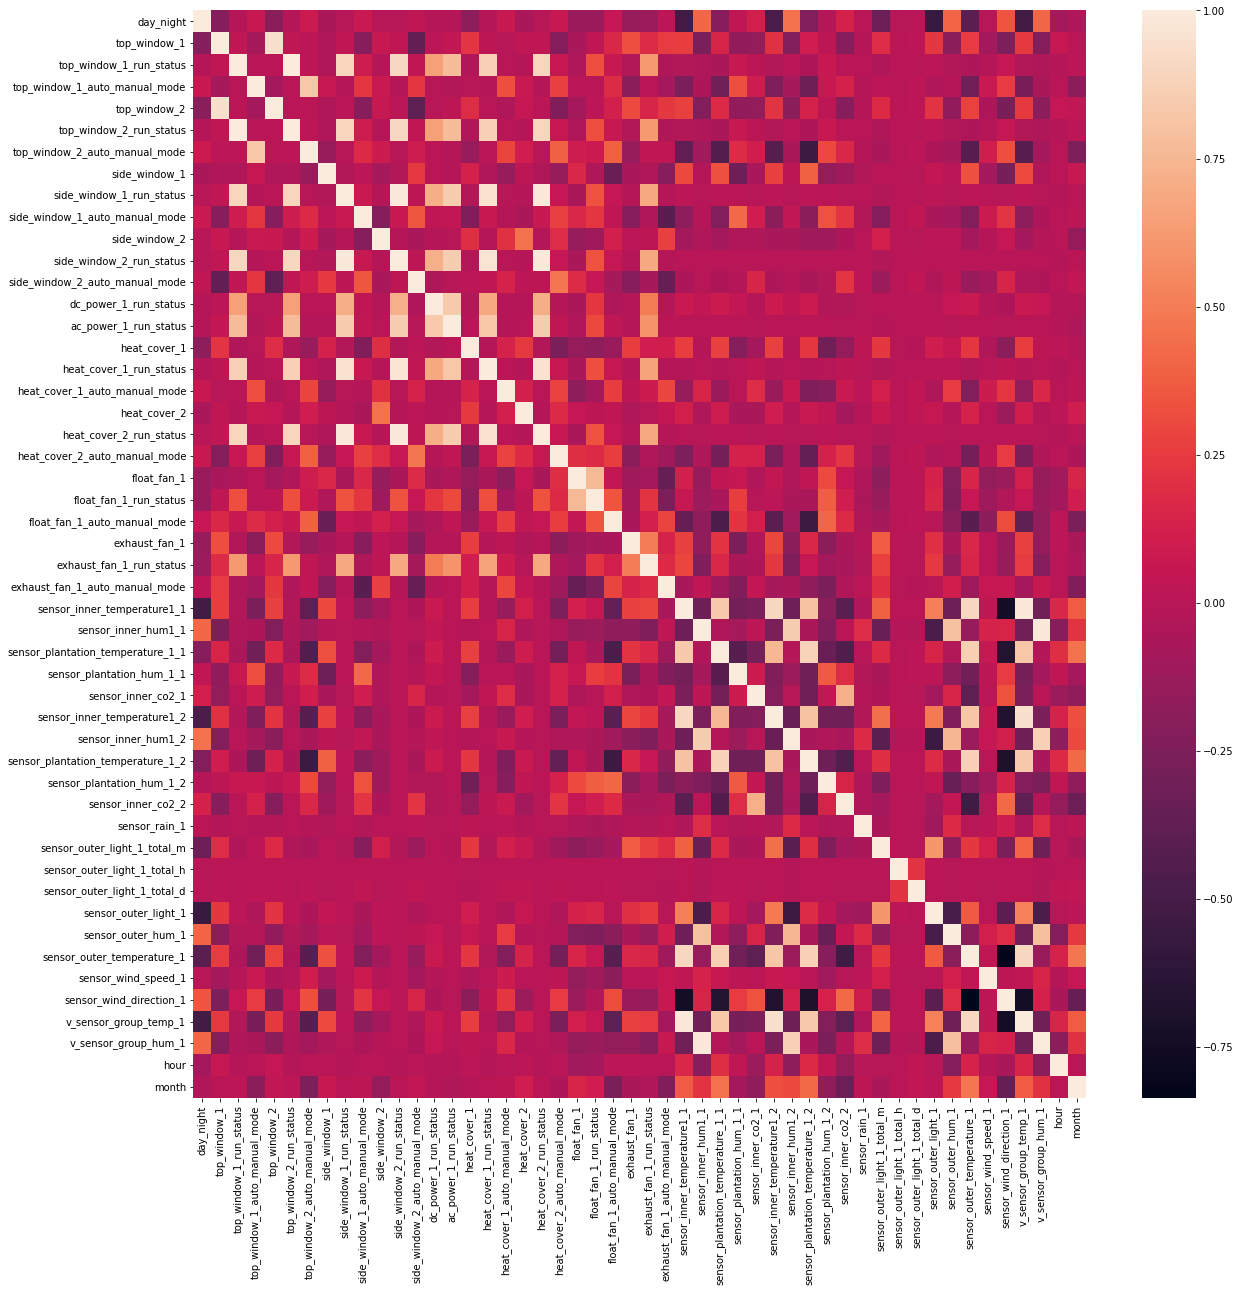

In [9]:
plt.figure(figsize = (20,20))
ax = sns.heatmap(monitor_hist.corr())
# ax = sns.heatmap(monitor_hist.corr()[['top_window_1_run_status']], annot = True)
plt.show() 

### - day_night

In [10]:
monitor_hist['day_night'].value_counts()

1    472884
2    430026
Name: day_night, dtype: int64

In [11]:
## 월별로 낮과 밤으로 넘어가는 시간이 앞뒤로 일부 겹침
for month in range(1,13):
    print(f"** {month}월 **")
    temp_df = monitor_hist[monitor_hist['month'] == month].copy()
    print(f"day_night 낮(1) 시간대 : {temp_df[temp_df['day_night'] == 1]['hour'].unique()}")
    print(f"day_night 밤(2) 시간대 : {temp_df[temp_df['day_night'] == 2]['hour'].unique()} \n")

** 1월 **
day_night 낮(1) 시간대 : [ 7  8  9 10 11 12 13 14 15 16 17]
day_night 밤(2) 시간대 : [ 0  1  2  3  4  5  6  7 17 18 19 20 21 22 23] 

** 2월 **
day_night 낮(1) 시간대 : [ 7  8  9 10 11 12 13 14 15 16 17 18]
day_night 밤(2) 시간대 : [ 0  1  2  3  4  5  6  7 18 19 20 21 22 23] 

** 3월 **
day_night 낮(1) 시간대 : [ 7  8  9 10 11 12 13 14 15 16 17 18  6]
day_night 밤(2) 시간대 : [ 0  1  2  3  4  5  6  7 18 19 20 21 22 23] 

** 4월 **
day_night 낮(1) 시간대 : [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19  5]
day_night 밤(2) 시간대 : [ 0  1  2  3  4  5  6 18 19 20 21 22 23] 

** 5월 **
day_night 낮(1) 시간대 : [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
day_night 밤(2) 시간대 : [ 0  1  2  3  4  5 19 20 21 22 23] 

** 6월 **
day_night 낮(1) 시간대 : [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
day_night 밤(2) 시간대 : [ 0  1  2  3  4  5 19 20 21 22 23] 

** 7월 **
day_night 낮(1) 시간대 : [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
day_night 밤(2) 시간대 : [ 0  1  2  3  4  5 19 20 21 22 23] 

** 8월 **
day_night 낮(1) 시간대 : [ 5  6  7  8  9 

### - window

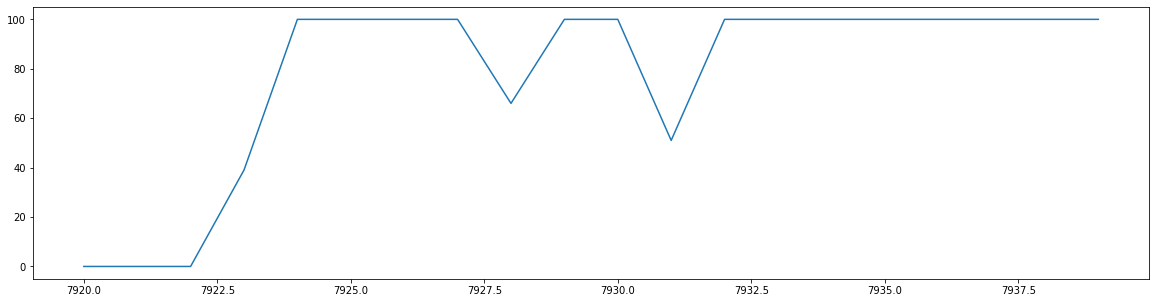

In [68]:
plt.figure(figsize = (20,5))
plt.plot(monitor_hist['top_window_1'][7920:7940])
plt.show()

In [13]:
window_list = ['top_window_1', 'top_window_2', 'side_window_1', 'side_window_2']

for window in window_list:
    print(f"\n** {window} info **")
    ## 0 ~ 100 사이의 값 보유
    print(monitor_hist[window].min(), monitor_hist[window].max())
    print(monitor_hist[window].nunique(), monitor_hist[window].unique().tolist())
    
    print(monitor_hist[monitor_hist['day_night'] == 1][window].mean(), monitor_hist[monitor_hist['day_night'] == 1][window].min(), monitor_hist[monitor_hist['day_night'] == 1][window].max())
    print(monitor_hist[monitor_hist['day_night'] == 2][window].mean(), monitor_hist[monitor_hist['day_night'] == 2][window].min(), monitor_hist[monitor_hist['day_night'] == 2][window].max())


** top_window_1 info **
0.0 100.0
101 [0.0, 16.0, 73.0, 100.0, 94.0, 82.0, 60.0, 39.0, 66.0, 51.0, 85.0, 25.0, 80.0, 63.0, 3.0, 48.0, 42.0, 57.0, 40.0, 71.0, 11.0, 53.0, 65.0, 5.0, 15.0, 81.0, 97.0, 37.0, 50.0, 18.0, 75.0, 4.0, 89.0, 61.0, 1.0, 74.0, 14.0, 84.0, 83.0, 23.0, 27.0, 79.0, 19.0, 13.0, 70.0, 21.0, 99.0, 24.0, 98.0, 6.0, 90.0, 32.0, 34.0, 78.0, 29.0, 31.0, 22.0, 10.0, 59.0, 47.0, 33.0, 8.0, 77.0, 17.0, 46.0, 30.0, 87.0, 95.0, 35.0, 92.0, 76.0, 86.0, 26.0, 68.0, 41.0, 96.0, 36.0, 91.0, 38.0, 44.0, 9.0, 93.0, 20.0, 52.0, 55.0, 49.0, 54.0, 62.0, 2.0, 69.0, 88.0, 28.0, 72.0, 45.0, 7.0, 43.0, 58.0, 64.0, 67.0, 56.0, 12.0]
39.082918855364106 0.0 100.0
19.480338398143367 0.0 100.0

** top_window_2 info **
0.0 100.0
101 [0.0, 60.0, 40.0, 100.0, 83.0, 27.0, 16.0, 1.0, 65.0, 5.0, 36.0, 68.0, 42.0, 77.0, 17.0, 70.0, 10.0, 95.0, 35.0, 69.0, 9.0, 21.0, 56.0, 62.0, 80.0, 20.0, 44.0, 93.0, 33.0, 76.0, 72.0, 12.0, 88.0, 28.0, 26.0, 78.0, 41.0, 64.0, 4.0, 2.0, 18.0, 92.0, 31.0, 87.0, 63.0, 

### - auto_manual_mode

In [14]:
for window in window_list:
    print(f"\n** {window} auto manual mode **")
    print(monitor_hist[f'{window}_auto_manual_mode'].unique().tolist())
    print(monitor_hist[f'{window}_auto_manual_mode'].value_counts())    


** top_window_1 auto manual mode **
[1, 0]
1    763470
0    139440
Name: top_window_1_auto_manual_mode, dtype: int64

** top_window_2 auto manual mode **
[1, 0]
1    714767
0    188143
Name: top_window_2_auto_manual_mode, dtype: int64

** side_window_1 auto manual mode **
[1, 0]
1    482964
0    419946
Name: side_window_1_auto_manual_mode, dtype: int64

** side_window_2 auto manual mode **
[1, 0]
0    452529
1    450381
Name: side_window_2_auto_manual_mode, dtype: int64


### - window_run_status

In [15]:
for window in window_list:
    print(f"\n** {window} run status **")
    print(monitor_hist[f'{window}_run_status'].unique().tolist())
    print(monitor_hist[f'{window}_run_status'].value_counts())    


** top_window_1 run status **
[0, 1, 2]
0    888651
2      7532
1      6727
Name: top_window_1_run_status, dtype: int64

** top_window_2 run status **
[0, 1, 2]
0    888762
2      7532
1      6616
Name: top_window_2_run_status, dtype: int64

** side_window_1 run status **
[0, 1, 2]
0    894858
2      7532
1       520
Name: side_window_1_run_status, dtype: int64

** side_window_2 run status **
[0, 1, 2]
0    895304
2      7532
1        74
Name: side_window_2_run_status, dtype: int64


In [16]:
## 고장 상태(2)이지만 창문이 완전히 열려있는 경우 존재
monitor_hist[monitor_hist['top_window_1_run_status'] == 2]['top_window_1'].value_counts()

0.0      4142
100.0    2577
92.0      813
Name: top_window_1, dtype: int64

In [26]:
## 동작 상태(1)이지만 창문이 완전히 닫혀있는 경우 존재 (6727건)
monitor_hist[monitor_hist['top_window_1_run_status'] == 1]['top_window_1'].value_counts()

6727

In [25]:
## 정지 상태(0)일 때 가장 많은 데이터값이 존재
monitor_hist[monitor_hist['top_window_1_run_status'] == 0]['top_window_1'].value_counts().sum()

888651

In [28]:
## 수동/자동일때 모두 다양한 상태값 존재
monitor_hist[monitor_hist['top_window_1_auto_manual_mode'] == 0]['top_window_1_run_status'].value_counts()

0    137667
2      1755
1        18
Name: top_window_1_run_status, dtype: int64

In [29]:
monitor_hist[monitor_hist['top_window_1_auto_manual_mode'] == 1]['top_window_1_run_status'].value_counts()

0    750984
1      6709
2      5777
Name: top_window_1_run_status, dtype: int64

In [19]:
temp = monitor_hist.copy()
for col in [col for col in list(monitor_hist) if 'sensor' in col]:
    # temp[f'temp_{col}_1'] = np.where((temp['top_window_1_run_status'] == 1) & (temp['top_window_1_auto_manual_mode']== 1), temp[col], np.NaN)
    # temp[f'temp_{col}_2'] = np.where((temp['top_window_2_run_status'] == 1) & (temp['top_window_1_auto_manual_mode']== 1), temp[col], np.NaN)
    # temp[f'temp_{col}_3'] = np.where((temp['side_window_1_run_status'] == 1) & (temp['side_window_1_auto_manual_mode']== 1), temp[col], np.NaN)
    # temp[f'temp_{col}_4'] = np.where((temp['side_window_2_run_status'] == 1) & (temp['side_window_2_auto_manual_mode']== 1), temp[col], np.NaN)
    
    temp[f'temp_{col}_1'] = np.where(temp['top_window_1_run_status'] == 1, temp[col], np.NaN)
    temp[f'temp_{col}_2'] = np.where(temp['top_window_2_run_status'] == 1, temp[col], np.NaN)
    temp[f'temp_{col}_3'] = np.where(temp['side_window_1_run_status'] == 1, temp[col], np.NaN)
    temp[f'temp_{col}_4'] = np.where(temp['side_window_2_run_status'] == 1, temp[col], np.NaN)

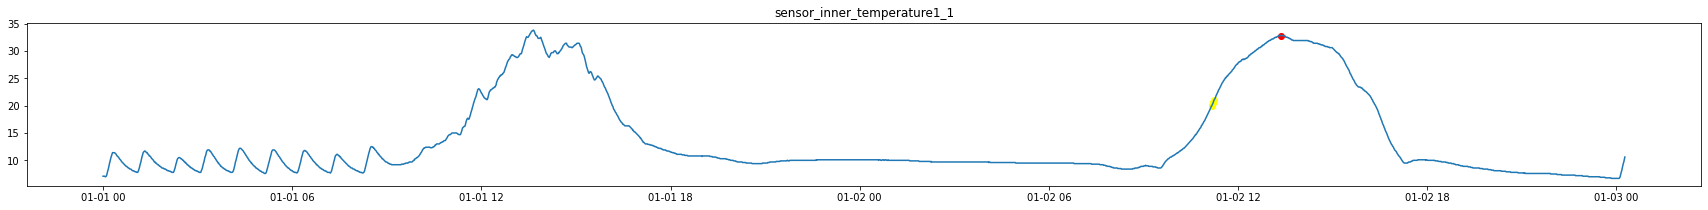

In [20]:
# temp = monitor_hist

# temp['event_date_min'] = temp['event_date_min'].astype('str')
# temp['date'] = temp['event_date_min'].str.split(' ', expand = True)[0]

# temp[temp['top_window_1_run_status'] == 1].value_counts('date').reset_index().head(20)

## runstatue = 1일 경우

st_idx = 24*60*0
ed_idx = 24*60*2

for col in [col for col in list(monitor_hist) if 'sensor' in col][:1]:
    plt.figure(figsize = (30,3))
    plt.plot(temp['event_date_min'][st_idx:ed_idx], temp[col][st_idx:ed_idx])
    plt.scatter(temp['event_date_min'][st_idx:ed_idx], temp[f'temp_{col}_1'][st_idx:ed_idx], c= 'red')
    plt.scatter(temp['event_date_min'][st_idx:ed_idx], temp[f'temp_{col}_2'][st_idx:ed_idx], c= 'orange')
    plt.scatter(temp['event_date_min'][st_idx:ed_idx], temp[f'temp_{col}_3'][st_idx:ed_idx], c= 'yellow')
    plt.scatter(temp['event_date_min'][st_idx:ed_idx], temp[f'temp_{col}_4'][st_idx:ed_idx], c= 'green')

    plt.title(col)
    plt.show()

## 추가 데이터 확인

In [30]:
device_type['kind'].unique()

array(['actuator', 'sensor_outer', 'sensor_reusable', 'sensor_inner',
       'v_device', 'nutrient'], dtype=object)

In [51]:
device_type[device_type['name'].str.contains('plantation')]

,id,name,description,last_update,device_type,device_type_name,device_type_group,kind,is_physical_device,manufacturer,...,accum_h,accum_d,value_mod,op_time,value_type,opmode_error,value_exchange,sensing_timeout,control_unit,graph_color
61,10301,sensor_plantation_temperature_1,배지온도1,2014-11-13 00:00:00,sensor_plantation_temperature_1,배지온도1,sensor_plantation_temperature,sensor_inner,1.0,KT,...,0,0,NaN,0,0,0,0,300,Ratio,NaN
62,10401,sensor_plantation_hum_1,배지습도1,2020-12-01 17:08:08,sensor_plantation_hum_1,배지습도1,sensor_plantation_hum,sensor_inner,1.0,KT,...,0,0,NaN,0,0,0,0,300,Ratio,#1f78b4
63,10501,sensor_plantation_ec,배지ec,2020-12-01 17:08:08,sensor_plantation_ec,배지ec,sensor_plantation_ec,sensor_inner,1.0,KT,...,0,0,NaN,0,0,0,0,300,Ratio,#fc8d62
64,10601,sensor_plantation_ph,배지ph,2014-11-13 00:00:00,sensor_plantation_ph,배지ph,sensor_plantation_ph,sensor_inner,1.0,KT,...,0,0,NaN,0,0,0,0,300,Ratio,NaN


In [47]:
for col in list(device_type):
    print(f"{col} : {device_type[device_type['name'] == 'sensor_inner_temperature1'][col].values}")

id : [10001]
name : ['sensor_inner_temperature1']
description : ['온도1']
last_update : ['2020-12-01 17:08:07']
device_type : ['sensor_inner_temperature1']
device_type_name : ['온도1']
device_type_group : ['sensor_inner_temperature']
kind : ['sensor_inner']
is_physical_device : [1.]
manufacturer : ['KT']
model_name : ['1']
model_spec : ['1']
model_version : ['1']
is_master : [0.]
use_house_type : [19]
default_address1 : ['temp1']
default_address2 : [nan]
default_address3 : [nan]
dcac : ['DC']
min_value : [-40.]
max_value : [80.]
description_i18n : ['__common.device_type.name.sensor_inner_temperature1']
device_type_name_i18n : ['__common.device_type.name.sensor_inner_temperature1']
unit : ['℃']
round_number : [1.]
topic_group : [nan]
reset_point : [0.]
accum_m : [0]
accum_h : [0]
accum_d : [0]
value_mod : [nan]
op_time : [0]
value_type : [0]
opmode_error : [0]
value_exchange : [0]
sensing_timeout : [300]
control_unit : ['Ratio']
graph_color : ['#e41a1c']


In [49]:
monitor_hist['sensor_inner_temperature1_1'].max()

68.1

In [48]:
monitor_hist['sensor_inner_temperature1_1'].min()

2.6

In [23]:
device_type.shape

(144, 38)